In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
# === Load từ Google Drive

def load_gdrive_csv(view_url):
    file_id = view_url.split('/')[-2]
    url = f'https://drive.google.com/uc?id={file_id}'
    return pd.read_csv(url, on_bad_lines='skip')

train_df = load_gdrive_csv(
    'https://drive.google.com/file/d/1tXDIoolBlOQzxj51LTWEQ1FPhiBnMbV7/view?usp=drive_link')
test_df = load_gdrive_csv(
    'https://drive.google.com/file/d/19TUYpvKBzMDGOsWczIwXsNnzF3-BOZBy/view?usp=drive_link')

# Tiền xử lý
def preprocess(df):
    for col in ['Price', 'Open', 'High', 'Low', 'Change %']:
        df[col] = df[col].astype(str).str.replace(',', '').str.replace('%', '').astype(float)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

train_df = preprocess(train_df)
test_df = preprocess(test_df)

In [3]:
# Cấu hình và hàm tạo dữ liệu
WINDOW_SIZE = 60
FEATURES = ['Price', 'Open', 'High', 'Low', 'Change %']
TARGET = 'Price'

def create_recursive_data(df, features, target, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        X_seq = df[features].iloc[i:i + window_size].values
        y_seq = df[target].iloc[i + window_size]
        X.append(X_seq)
        y.append(y_seq)
    return np.array(X), np.array(y)

# Ghép thêm 60 ngày cuối của train vào test
merged_df = pd.concat([train_df.tail(WINDOW_SIZE), test_df], axis=0).reset_index(drop=True)
X_train, y_train = create_recursive_data(train_df, FEATURES, TARGET, WINDOW_SIZE)
X_test, y_test = create_recursive_data(merged_df, FEATURES, TARGET, WINDOW_SIZE)

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [4]:
# GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

base_model = LGBMRegressor(objective='regression', random_state=42, force_col_wise=True, verbosity=-1)
model = GridSearchCV(base_model, param_grid, cv=3, n_jobs=-1)
multi_model = MultiOutputRegressor(model)
multi_model.fit(X_train_flat, y_train.reshape(-1, 1))

MultiOutputRegressor(estimator=GridSearchCV(cv=3,
                                            estimator=LGBMRegressor(force_col_wise=True,
                                                                    objective='regression',
                                                                    random_state=42,
                                                                    verbosity=-1),
                                            n_jobs=-1,
                                            param_grid={'learning_rate': [0.01,
                                                                          0.05,
                                                                          0.1],
                                                        'max_depth': [3, 5, 7],
                                                        'n_estimators': [100,
                                                                         200]}))

In [5]:
# Dự báo test
y_pred = multi_model.predict(X_test_flat)

# Dự báo 30 ngày tiếp theo bằng Recursive Prediction
def recursive_predict(model, last_sequence, n_steps):
    preds = []
    seq = last_sequence.copy()
    for _ in range(n_steps):
        input_flat = seq.reshape(1, -1)
        next_pred = model.predict(input_flat)[0][0]
        preds.append(next_pred)
        next_row = seq[-1].copy()
        next_row[0] = next_pred
        seq = np.vstack((seq[1:], next_row))
    return preds

last_seq = merged_df[FEATURES].iloc[-WINDOW_SIZE:].values
future_preds = recursive_predict(multi_model, last_seq, 30)

In [6]:
# Đánh giá
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred.ravel()) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE   = {mae:.4f}")
print(f"MSE   = {mse:.4f}")
print(f"RMSE  = {rmse:.4f}")
print(f"MAPE  = {mape:.2f}%")
print(f"R²    = {r2:.4f}")


MAE   = 0.0093
MSE   = 0.0003
RMSE  = 0.0179
MAPE  = 0.95%
R²    = 0.6338


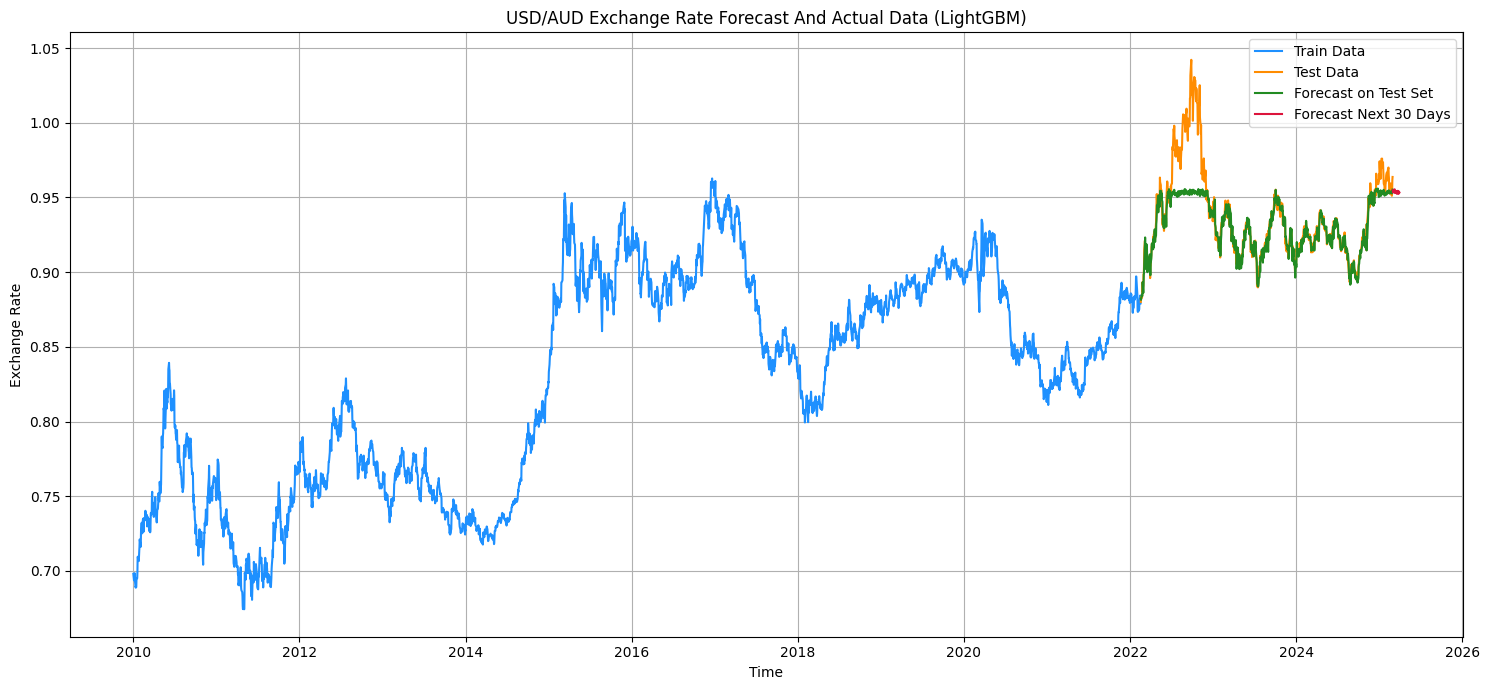

In [7]:
# Biểu đồ 1
plt.figure(figsize=(15, 7))
plt.plot(train_df['Date'], train_df['Price'], label='Train Data', color='dodgerblue')
plt.plot(test_df['Date'], test_df['Price'], label='Test Data', color='darkorange')
test_all_df = pd.concat([train_df.tail(WINDOW_SIZE), test_df], ignore_index=True)
plt.plot(test_all_df['Date'].iloc[WINDOW_SIZE:], y_pred.ravel(), label='Forecast on Test Set', color='forestgreen')

future_dates = pd.date_range(start=test_df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=30)
plt.plot(future_dates, future_preds, label='Forecast Next 30 Days', color='crimson')
plt.title("USD/AUD Exchange Rate Forecast And Actual Data (LightGBM)")
plt.xlabel("Time")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


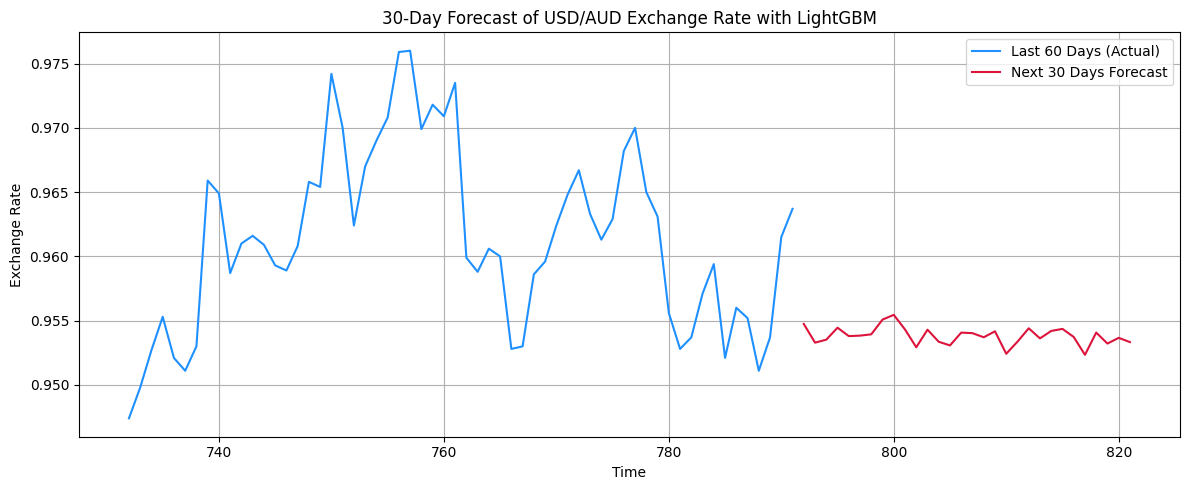

In [8]:
# Biểu đồ 2
plt.figure(figsize=(12, 5))
last_60_prices = test_df['Price'].iloc[-60:]
plt.plot(last_60_prices.index, last_60_prices.values, label="Last 60 Days (Actual)", color="dodgerblue")
plt.plot(range(last_60_prices.index[-1] + 1, last_60_prices.index[-1] + 31), future_preds,
         label="Next 30 Days Forecast", color="crimson")
plt.title("30-Day Forecast of USD/AUD Exchange Rate with LightGBM")
plt.xlabel("Time")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
